In [1]:
using BenchmarkTools, SpecialFunctions
using LinearAlgebra, Statistics
using Plots
using Random, Distributions
gr(fmt=:png); # setting for easier display in jupyter notebooks

**Introduction**

I'm teaching myself ``julia``. The simplest way for me todo so is to work with a model that I know extremely well---the Ricardian model of Eaton and Kortum (2002). So below I will outline the economic environment and then use the properties of ``julia`` to map the fundamental, mathematical environment into a computational/quantitative outcome. 

Outside of performance properties, the more I reflect on this, this is a huge appeal of the ``julia`` language. We can express the code and design it in a way that most closely corresponds with the math/model. In contrast, in for example MATLAB, where the map from white board to computation is big.

---

**Countries.** To keep things simple, let's first work with a simple two country set up---a home and a foreign country, $h$, $f$.

**Individual Goods Production.**
Within a country, there is a continuum of intermediate goods indexed by $\omega \in [0, 1]$. As in the Ricardian model of \citet{dornbusch1977comparative} and \citet{eaton2002technology}, intermediate goods are not nationally differentiated. Thus, intermediate $\omega$ produced in one country is a perfect substitute for the same intermediate $\omega$ produced by another country. Competitive firms produce intermediate goods with linear production technologies:

\begin{align}
q(\omega) = z(\omega) \ell,
\end{align}

where $z$ is the productivity level of firms and $\ell$ is the number of efficiency units of labor. To ship a technology to another country, iceberg costs are incurred. I will write this as $\tau_{hf}$ which is the value the home country must incur to buy from the foreign country. The notation here will correspond with the row, column format of a matrix, so for a given row all the trade costs across the different columns are the ones that they face to buy from different countries. Then the usual normalization here is that $\tau_{hh} = 1$. Again, on the computer, this means that the diagonal entries are one.

**The Aggregator.** In this model, intermediate goods are aggregated by a competitive final-goods producer. In Julia, what would be interesting is to make the aggregator generic and let the user specify how this works. But for know, we will follow the canonical situation with  who has a standard CES production function:

\begin{align}
Q = \left[ \int_0^1 q(\omega)^{\frac{\sigma - 1}{\sigma}} d\omega \right]^{\frac{\sigma}{\sigma - 1}},
\label{eq:ces}
\end{align}

where $q(\omega)$ is the quantity of individual intermediate goods $\omega$ demanded by the final-goods firm, and $\sigma$ is elasticity of substitution across variety. I want to talk through some properties/definitions related to this aggregator.

- The aggregator in (\ref{eq:ces}) gives rise to the following the demand curve (in quantities) for an individual variety:

\begin{align}
q(\omega) & = \left(\frac{p_h(\omega)}{P_h}\right)^{-\sigma}Q.
\label{eq:demand_curve}
\end{align}

where $Q$ is the aggregate demand for the final good; $P_h$ is the CES price index, defined below; And $p_h(\omega)$ is the price paid by the home country for good $\omega$ (which is not the same necessarily as the price offered by a home country supplier.

- The demand curve can also be expressed in shares, not quantities. So

\begin{align}
\frac{p_h(\omega)q(\omega)}{P_h Q} & = \left(\frac{p_h(\omega)}{P_h}\right)^{1-\sigma}.
\label{eq:demand_curve_share}
\end{align}

which says that the value of of good $\omega$ relative to total expenditures $P_h Q$ is given by the formula above. This helps as we can compute expenditure patterns while being agnostic about the actual size of the economy, i.e. $Q$. One useful relationship that builds on this is to condition on the source and aggregate to arrive at the share of goods purchased from another country. How does this work? 

\begin{align}
\pi_{h,f} = \int_{p_h = p_{h,f}} \left(\frac{p_h(\omega)}{P_h}\right)^{1-\sigma} d\omega
\end{align}

Where the notation here $\pi_{h,f}$ is the share of goods that the home country sources from the foreign country. This is equal do the integral over all goods purchased from them, hence, the conditioning where $p_h = p_{h,f}$ and then the inside of the brackets is the same as above. In the computer, the code will be setup with the same row, column notation. So fix a row, then as you go across the different columns you'll view the share of expenditures the, say home country, coming from other countries. 

A small side note: If you stare at this enough (and know the liturature), than you can start to see a gravity like relationship here without even imposing the Frechet assumption. The key issue essentially is the conditional distribution of goods prices and how it relates to the aggregate, home CES price index discussed next.

- The **CES Price Index** is given by

\begin{align}
P_h  = \left [ \int_{0}^{1} p_h(\omega)^{1-\sigma} d\omega \right]^{\frac{1}{1-\sigma}}
\label{eq:ces_price_index}
\end{align}

which takes all the prices at the micro-level and the is like a harmonic mean of these prices. Also note how one can substitute \ref{eq:ces_price_index} into the share formula to get an expression of expenditures shares purely in terms of micro-level prices.

**The Technology Distribution** 

This is the key component that makes Eaton and Kortum fly. First, let's be a bit more general here. One could simply think of each countries **individual productivity** draws being characterized by some distribution:

\begin{align}
Z_h \sim F_{h}(z)
\end{align}

where $F_{h}$ is a well defined cumulative probability distribution with the associated pdf $f_h(z)$. What this means is for each $\omega$ variety, in say the home country, the technology/productivity to produce that good is a random $z$ which is characterized by the distribution above. As I'll talk about below, what this allows one to think about is (i) if you hand me a distribution from which I can simulate from (ii) then with assumptions on market structure I can construct prices and (iii) with prices I can construct trade flows.

Now Eaton and Kortum make a very specific distributional assumption. They use a Type II extreme value distribution also known as a Frechet:

\begin{align}
Z_i \sim \exp\left(-T_i z^{-\theta}\right)
\end{align}

where the distribution is characterized by a centering parameter $T_i$ which is allowed to vary across countries and a shape parameter $\theta$ which is assumed to be constant across countries. These assumptions are critical to the closed form characterizations in Eaton and Kortum. However, return to the discussion above. On the computer..there are only two limiting factors (i) can you simulate from the distribution and (ii) the empirical question of how to discipline the distribution from which you are simulating. 

**Optimization** 

I'm going to walk through a couple of observations about how this economy works.

The first observation is that within a country, the key equilibrium price is the wage rate $w$. This wage is the same independent of the labor market / goods-producing sector / etc. This derives from the (within-country) free mobility of labor assumption (which I did not talk about). In some other notebooks, I'll relax this. But for now, labor is freely mobile and now we just need to find the wage so that labor demand equals labor supply. 

The second observation is that given competitive firms and that they face the wage rate $w$, we know that their marginal cost (and hence price at which they are willing to sell the good domestically) must be:

\begin{align}
p_{h,h}(\omega) = \frac{w_{h}}{z_{h}(\omega)},
\label{eq:ek_wage}
\end{align}

and then the price at which they would be willing to export the good, say from home to foreign is just adjusted by the ice-berg trade costs so 

\begin{align}
p_{f,h}(\omega) = \frac{\tau_{f,h} w_{h}}{z_{h}(\omega)}.
\end{align}

The third question is who buys what from whom? This aspect of the model is that really is just an application of the min operator. So buy the good from the country with the lowest price:

\begin{align}
p_{h}(\omega) = \min\left\{ \frac{w_{h}}{z_{h}(\omega)}, \ \frac{\tau_{h,f} w_{f}}{z_{f}(\omega)} \right\}
\end{align}

where the thing on the left is the domestic price, and then the thing on the right is on the world price (inclusive of the trade cost).

**Computing**

First, I'm going to compute this via simulation. The idea will be to think of the product space $\omega$ as an integer on the real line which indexes the goods location. Then for each of those products, each country is randomly assigned a productivity from the distribution. Then the number of goods, so to speak, is set to be large and thus will approximate the integrals above. 

Given everything laid out, some wages $w_i$ and then primitives regarding technologies $T$, $\theta$, $\sigma$ and $\tau$ we can directly compute the pattern of trade. This is what I do below which is comprised of several steps:

- The CES function ``ces_shares`` that takes prices and sourcing decisions to compute trade shares.

- A function that computes potential prices based on marginal costs, ``marginal_costs``

- A function that constructs a vector of productivity for each good, across all countries, given the Frechet distribution, this is the ``make_productivity`` function. Note, future, it would be nice if the distribution type could be directly passed into this and also appropriately indexed. Maybe with a dictionary?

**Equilibrium**

I'm going to present this in a way slightly different than usual. So I want to think of the wage as clearing the labor market. This implies that goods demand will equal goods supply which will reduce to balanced trade. The idea here is to build up into some later notebooks where we can think of more sophisticated labor market settings with elastic labor supply, mobility/migration frictions similar to my work with Spencer.

**Labor Demand** so the key idea here is the the CES demand curve also is a labor demand curve when combined with the production function. First, consider the simple case of a closed economy. Here we have:

\begin{align}
\ell(\omega) & = \frac{1}{z(\omega)}\left(\frac{w / z(\omega)}{P_h}\right)^{-\sigma}Q.
\label{eq:labor_demand_curve}
\end{align}

where I substituted in the price equaling marginal costs, which after pulling things out we have that

\begin{align}
\ell_h(\omega) & = z_h(\omega)^{\sigma - 1}\left(\frac{w_h}{P_h} \right)^{-\sigma}Q.
\label{eq:demand_curve2}
\end{align}

which has the inuitive idea that (i) if productivity is high or aggregate demand is high you need **more workers** and (ii) if the wage is high you demand less workers. Now let's extend this to the open economy setting. So labor demand is

\begin{align}
\ell_h(\omega) & = \underbrace{\frac{1}{z_h(\omega)}\left(\frac{w_h / z_h(\omega)}{P_h}\right)^{-\sigma}Q_h}_{\mbox{domestic demand}} \ + \ \underbrace{\frac{1}{z_h(\omega)}\left(\frac{\tau_{f,h} w_h / z_h(\omega)}{P_f}\right)^{-\sigma}Q_f}_{\mbox{foreign demand}}
\end{align}

where again, I substituted in the price for good $\omega$ in the domestic demand curve and (if purchased) into the foreign demand curve. Note that this is a generic representation in the sense that domestic demand and foreign demand might be zero. In this case, the good is imported from abroad. Or it might be only domesticly demanded (which in this cases the good is non traded) and then it's both bought at home and sent abroad. 

The one way to think about an equilibrium is we need to find a wage such labor supply equals labor demand. So 

\begin{align}
L_h = \int \ell_h(\omega) d\omega = \int_{p_h = p_{h,h}} \frac{1}{z(\omega)}\left(\frac{w_h / z(\omega)}{P_h}\right)^{-\sigma}Q_h + \int_{p_f = p_{f,h}} \frac{1}{z(\omega)}\left(\frac{\tau_{f,h} w_h / z(\omega)}{P_f}\right)^{-\sigma}Q_f
\end{align}

In [2]:
function ces_shares(p, source_country::Matrix{CartesianIndex{2}}, σ)
    # this will take in (i) prices purchased at and
    # a cartesian index that can determine country supplier
    # then a parameter for the CES aggregator.
    # I'm toying around with explicity typing here. Any thoughts?
    # When presented this way. One can see how any arbitrary aggregator could be put in place.
    
    ngoods = length(p) # number of goods
    
    ncntry = ndims(source_country) # number of coutnries
    
    price_index = ( sum(p.^(1-σ)) / ngoods )^(1/(1-σ)) # CES price index
    
    # now construct the shares...
    trade_shares = zeros(ncntry)
    
    source_prob = zeros(ncntry)
    
    for cntry = 1:ncntry
        # This is the loop that conditions on the source country
        # first fix a country...

        supplier = [ zzz[2] == cntry for zzz in source_country ]
        # remember that the source_country is a 2dim caartesian index which
        # says for each good (first dimension), which country is the low cost 
        # supplyier (second country)
        # this is then a simple inline expression saying, for each 
        # good (so every entry along the first dimension), which values in the second 
        # dimension zzz[2] are equall to the country in question "cntry" 
        # the result is supplier which is a vector of logicals, with true (one)
        # values indicating that "cntry: is the low cost supplier
        
        source_prob[cntry] = sum(supplier) / ngoods
        # This will compute the simple probability of being the low cost 
        # supplier. In the Frechet model = trade share. Alternative distributional
        # assumptions will deliver something different.
        
        trade_shares[cntry] = sum((p[supplier]./price_index).^(1-σ)) / ngoods
        # then this is just the ces demand curve described above.
        
    end
        
    return price_index, trade_shares, source_prob

end

ces_shares (generic function with 1 method)

In [3]:
function marginal_cost(z, wage, τ)
    
    return (τ.*wage)./z

end

marginal_cost (generic function with 1 method)

In [4]:
function make_productity(T ,θ , ngoods)
    
    seed = 3281978
    
    ncntry = length(T)
    
    z = zeros(ngoods,ncntry)
    
    for cntry = 1:ncntry
    
        dist = Frechet(θ, T[cntry]^(1/θ))
        # Ideally, it would be cool to potentially be able to pass as an argument
        # the distibution for each country or something like that.
    
        z[:,cntry] = rand(MersenneTwister(seed + cntry), dist, ngoods, 1);
        #I tried the rand! command (if modifies the argument),
        # it did not work...seemed to rewrite everytime
        # this thing looped through.
        # MersenneTwister is the seed setter for the random number generator...
        # works simmilar to matlab...takes an integer and then specifies
    
    end
    
    return z
    
end

make_productity (generic function with 1 method)

In [8]:
function low_cost_supplier(z, w, τ)
    
    return p, source_country = findmin(marginal_cost(z, w, τ); dims = 2);
    
end

low_cost_supplier (generic function with 1 method)

In [15]:
tau_matrix = [1 1.5; 1.5 1]
T = [1.0 2.0]
w = [1.0 1.0]
θ = 4.0

ncntry = ndims(tau_matrix)
ngoods = 1000000

@time z = make_productity(T,θ,ngoods)
# this is the slow part of the code, not the min part...

price_index = zeros(ncntry)
shares = zeros(ncntry,ncntry)
source_prob = zeros(ncntry,ncntry)
source_country = Array{CartesianIndex{2}}(undef, ngoods, ncntry)

for cntry = 1:ncntry

    @time p, sc = low_cost_supplier(z, w, tau_matrix[cntry,:]');
    # find the min over marginal costs
    # note that the tau_matrix returns a vector, not a row vector as I was anticipating
    # so take the transpose to make it work.

    @time (price_index[cntry], shares[cntry,:], source_prob[cntry,:]) = ces_shares(p, sc, 2.0);
    # then this is set up so the row is the buyer...then you go across the columns
    # and that is share of goods the home country buys from that country.
    
    source_country[:, cntry] = sc
end

  0.267778 seconds (30 allocations: 30.556 MiB, 0.80% gc time)
  0.020707 seconds (17 allocations: 38.148 MiB)
  0.036572 seconds (27 allocations: 24.797 MiB, 6.24% gc time)
  0.018118 seconds (17 allocations: 38.148 MiB)
  0.026651 seconds (27 allocations: 24.797 MiB)


In [13]:
shares

2×2 Matrix{Float64}:
 0.716508   0.283492
 0.0899421  0.910058

In [5]:
tau_matrix = [1 1.5; 1.5 1]
T = [1.0 2.0]
w = [1.0 1.0]
θ = 4.0

4.0

In [7]:
tau_matrix[1,:]

2-element Vector{Float64}:
 1.0
 1.5

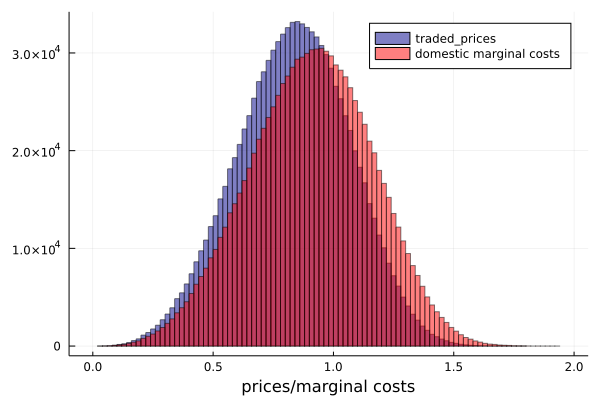

In [74]:
p, ~ = low_cost_supplier(z, w, tau_matrix[1,:]);

mc = marginal_cost(z, w, tau_matrix[1,:]');

histogram(p, bins = 100, alpha = 0.5, color = "dark blue", label = "traded prices", xlabel = "prices/marginal costs")
histogram!(mc[:,1], bins = 100, alpha = 0.5, color = "red", label = "domestic marginal costs")

In [298]:
function labor_demand(source_country::Matrix{CartesianIndex{2}}, z::Matrix{Float64}, 
        w::Matrix{Float64}, τ::Matrix{Float64}, price_index::AbstractArray,
        Q::AbstractArray, country::Int64, σ::Float64)
    
    destinations = Array{Bool}(undef, size(z))

    for cntry = 1:ncntry
        # This is the loop that conditions on the source country
        # first fix a country...

        destinations[:, cntry] = [ zzz[2] == country for zzz in source_country[:, cntry] ]
        # this is different than the ces demand line. it says for a given country, go through 
        # each country low cost supplier and find the places where that given country is the
        # low cost supplier. 
        # Then the destination country is a matrix of bools so indicating if country
        # is the low cost supplier to those different (columns) destiation. 
        # really this is like from the exporter side....
        
    end
    
    mc = marginal_cost(z[:, country], w, τ[:, country]')
    
    lbr_dmnd = (1 ./ z[:, country]).*(mc ./ price_index').^(-σ).*Q' ./ ngoods
        
    return lbr_dmnd.*destinations
    
end

labor_demand (generic function with 7 methods)

  240.649 ms (66 allocations: 95.37 MiB)


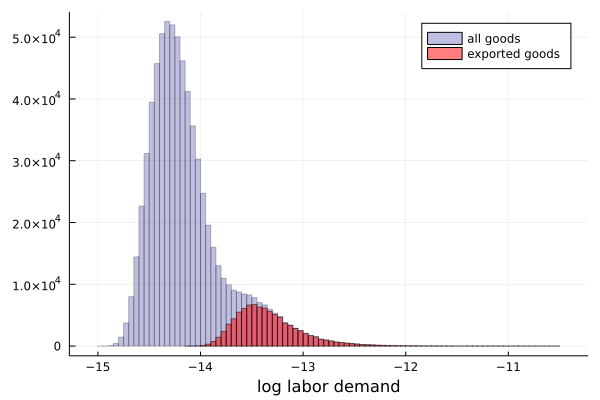

In [300]:
@btime ld = labor_demand(source_country, z, w, tau_matrix, price_index, [1 ;1], 1, 2.0);

lall = sum(ld[ld[:,1] .> 0.0, :], dims = 2)

lexp = sum(ld[ld[:,2] .> 0.0, :], dims = 2)

histogram(log.(lall), bins = 100, alpha = 0.25, color = "dark blue", xlabel = "log labor demand", label = "all goods")

histogram!(log.(lexp), bins = 100, alpha = 0.5, color = "red", label = "exported goods")

In [304]:
using Optim
#https://github.com/JuliaNLSolvers/Optim.jl
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = optimize(rosenbrock, zeros(2), BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     5.471433e-17

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 3.47e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.47e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e+03 ≰ 0.0e+00
    |g(x)|                 = 2.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    16
    f(x) calls:    53
    ∇f(x) calls:   53


In [302]:
import Pkg; Pkg.add("Optim")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed ArrayInterface ───────── v3.1.11
   Installed DiffRules ────────────── v1.0.2
   Installed FiniteDiff ───────────── v2.8.0
   Installed PositiveFactorizations ─ v0.2.4
   Installed IfElse ───────────────── v0.1.0
   Installed Static ───────────────── v0.2.4
   Installed ForwardDiff ──────────── v0.10.18
   Installed Optim ────────────────── v1.3.0
   Installed UnPack ───────────────── v1.0.2
   Installed NLSolversBase ────────── v7.8.0
   Installed DiffResults ──────────── v1.0.3
   Installed LineSearches ─────────── v7.1.1
   Installed Parameters ───────────── v0.12.2
   Installed CommonSubexpressions ─── v0.3.0
    Updating `~/.julia/environments/v1.6/Project.toml`
  [429524aa] + Optim v1.3.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [4fba245c] + ArrayInterface v3.1.11
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.0.3
  [b552c78f] + DiffRules